# Feed-forward neural network

Goals:
- hand-code the feed-forward neural network on a toy dataset
- train the algorithm
- estimate the error

## Import basic libraries

In [1]:
import numpy as np
from matplotlib import pyplot as plt

%matplotlib inline

## Load a toy dataset

In [2]:
N = 100
W = 32
H = 32
D = W * H

data = np.empty((N, D))

from PIL import Image
for i in range(N):
    filename = f'xo/{i+1:03}.png'
    image = Image.open(filename)
    arr = np.asarray(image)
    arr = arr.reshape(D)
    data[i] = arr

## Visualize the toy dataset

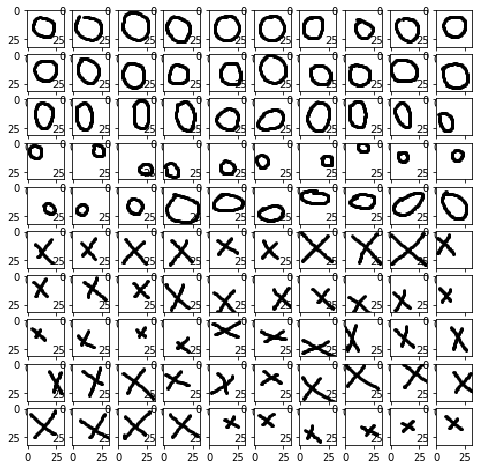

In [3]:
rows = 10
cols = 10
fig=plt.figure(figsize=(8, 8))
for i in range(cols * rows):
    img = data[i].reshape((W, H))
    fig.add_subplot(rows, cols, i + 1)
    plt.imshow(img, cmap="gray")
plt.show()

## Add labels and shuffle

In [4]:
labels = np.array([[0.0] * 50 + [1.0] * 50])
data = np.column_stack((data, labels.reshape(N, 1)))
np.random.shuffle(data)

In [5]:
data[:15]

array([[255., 255., 255., ..., 255., 255.,   1.],
       [255., 255., 255., ..., 255., 255.,   1.],
       [255., 255., 255., ..., 255., 255.,   1.],
       ...,
       [255., 255., 255., ..., 255., 255.,   0.],
       [255., 255., 255., ..., 255., 255.,   0.],
       [255., 255., 255., ..., 255., 255.,   0.]])

## Prepare the data

### Split into training set and validation set

In [6]:
M = 20

X_train = data[:-M, :-1] / 255
T_train = np.column_stack((data[:-M, -1:], 1.0 - data[:-M, -1:]))

X_test = data[-M:, :-1] / 255
T_test = np.column_stack(( data[-M:, -1:], 1.0 - data[-M:, -1:]))

### Plot the train and test data

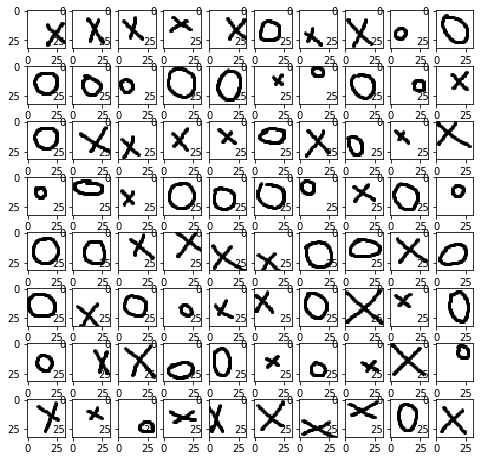

In [7]:
rows = 8
cols = 10
fig=plt.figure(figsize=(8, 8))
for i in range(cols * rows):
    img = X_train[i].reshape((W, H))
    fig.add_subplot(rows, cols, i + 1)
    plt.imshow(img, cmap="gray")
plt.show()

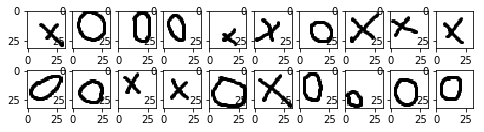

In [8]:
rows = 2
cols = 10
fig=plt.figure(figsize=(8, 2))
for i in range(cols * rows):
    img = X_test[i].reshape((W, H))
    fig.add_subplot(rows, cols, i + 1)
    plt.imshow(img, cmap="gray")
plt.show()

## Build neural network

In [9]:
import math

# learning rate
alpha = 0.001
    
# 10 hidden neurons
NH = 10

# 2 output neurons
NO = 2

In [10]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

In [11]:
class NeuralNetwork:
    # hidden weights, Xavier initialization
    WH = np.random.randn(NH, D) * math.sqrt(2.0 / D)

    # Output layer weights, Xavier initialization
    WO = np.random.randn(NO, NH) * math.sqrt(2.0 / NH)
    
    X = None
    HO = None
    OO = None
    Y = None
    
    def forward(this, X):
        # remember input
        this.X = np.copy(X)
        
        # hidden layer calculations
        this.HO = X.dot(this.WH.T)
        HO_sigmoid = sigmoid(this.HO)
        
        # output layer calculations
        this.OO = HO_sigmoid.dot(this.WO.T)
        this.Y = sigmoid(this.OO)
        
        return np.copy(this.Y)
    
    def backprop(this, T):
        # gradient on the error function
        err_grad = this.Y - T
                         
        # gradient on the output layer
        grad_o = err_grad * (1 - sigmoid(this.OO)) * sigmoid(this.OO)
        # gradient going to the weights of the output layer
        grad_w = grad_o.T.dot(this.HO)
        
        # gradient going to the neurons of the hidden layer
        grad_h = grad_o.dot(this.WO)

        # gradient on the hidden layer
        grad_h1 = grad_h * (1 - sigmoid(this.HO)) * sigmoid(this.HO) 
        
        # gradient going to the weights of the hidden layer
        grad_wh = grad_h1.T.dot(this.X)
        
        # update weights
        this.WO = this.WO - alpha * grad_w
        this.WH = this.WH - alpha * grad_wh

## Train the network

In [12]:
def cross_entropy(T, Y):
    return -np.mean(T * np.log(Y) + (1 - T) * np.log(1 - Y))

In [13]:
nn = NeuralNetwork()

### Weights before training

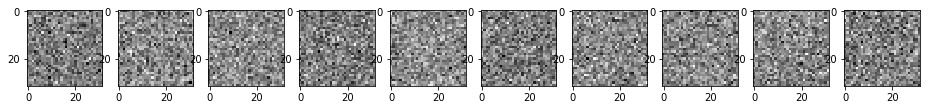

In [14]:
rows = 1
cols = 10
fig=plt.figure(figsize=(16, 16))
for i in range(nn.WH.shape[0]):
    img = nn.WH[i].reshape((W, H))
    fig.add_subplot(rows, cols, i + 1)
    plt.imshow(img, cmap="gray")
plt.show()

### Error before training

In [15]:
Y_train = nn.forward(X_train)
cross_entropy(T_train, Y_train)

0.7117793880055208

### Gradient descent

In [16]:
# get starting error
Y_train = nn.forward(X_train)
err_prev = cross_entropy(T_train, Y_train)

# counter
cnt = 0

# error_delta
err_delta = 0.000001

while True:
    # print error every 1000 steps
    if cnt % 1000 == 0:
        print('error: ' + str(err_prev))
    cnt = cnt + 1
    
    # gradient descent
    nn.backprop(T_train)
    
    # re-evaluate model
    Y_train = nn.forward(X_train)
    err = cross_entropy(T_train, Y_train)

    # check if trained
    if abs(err - err_prev) < err_delta:
        break
    err_prev = err


print('final error: ' + str(err))
print('iterations: ' + str(cnt))

error: 0.7117793880055208
error: 0.08273186912087829
error: 0.039646359212157346
error: 0.028117767077535282
error: 0.02255522567396109
error: 0.019195731143015055
error: 0.01691045002923211
error: 0.015236883733994271
error: 0.013948177076390445
final error: 0.013280092190475257
iterations: 8625


### Validate the model

In [17]:
Y_test = nn.forward(X_test)
validation_err = cross_entropy(T_test, Y_test)
validation_err

0.5730200817267989

In [18]:
softmax = np.exp(Y_test[:, 0]) / np.sum(np.exp(Y_test), axis=1)
labels = np.where(softmax < 0.5, 0.0, 1.0)

### Show predicted correctly

In [19]:
correct = X_test[np.argwhere(T_test[:, 0] == labels)]
correct = correct.reshape(correct.shape[0], D)

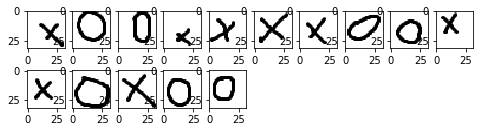

In [20]:
rows = 2
cols = 10
fig=plt.figure(figsize=(8, 2))
for i in range(correct.shape[0]):
    img = correct[i].reshape((W, H))
    fig.add_subplot(rows, cols, i + 1)
    plt.imshow(img, cmap="gray")
plt.show()

### Show predicted incorrectly

In [21]:
incorrect = X_test[np.argwhere(T_test[:, 0] != labels)]
incorrect = incorrect.reshape(incorrect.shape[0], D)

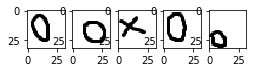

In [22]:
rows = 2
cols = 10
fig=plt.figure(figsize=(8, 2))
for i in range(incorrect.shape[0]):
    img = incorrect[i].reshape((W, H))
    fig.add_subplot(rows, cols, i + 1)
    plt.imshow(img, cmap="gray")
plt.show()

### Weights after training

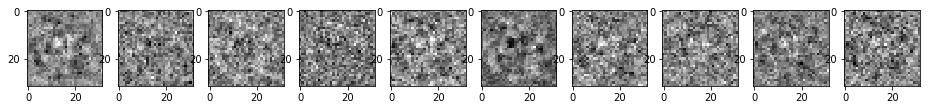

In [23]:
rows = 1
cols = 10
fig=plt.figure(figsize=(16, 16))
for i in range(nn.WH.shape[0]):
    img = nn.WH[i].reshape((W, H))
    fig.add_subplot(rows, cols, i + 1)
    plt.imshow(img, cmap="gray")
plt.show()

## Conclusions

- The neural network guessed about 60% correctly on the test set
- There is obviously too little data
- It's fun however to watch the weights update